In [76]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                      # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to double
torch.set_default_dtype(torch.double)

#PyTorch random number generator
torch.manual_seed(1234)      

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 定义 Double Well Potential
def V(x, T):
    
    # 
    # c = T*(24/5.5*(T-0.5)+12)*0.06
    F = (x**2 / 2 + (T - 2) / 2)**2 + ((T - 2)**2 - 1)**2 / 2
    return F * T
def boltzmann_probability(V_x, x_vals, T_vals, kb=1.0):
    """
    Compute the normalized Boltzmann probability density function (PDF).

    Parameters:
    - V_x: Potential energy at each (x, T)
    - x_vals: Positions x
    - T_vals: Temperatures T
    - kb: Boltzmann constant (default = 1)

    Returns:
    - Normalized probability density function P(x, T)
    """
    P_xT = torch.exp(-V_x / (kb * T_vals))  # Compute unnormalized probability
    dx = (x_vals[-1] - x_vals[0]) / (len(x_vals) - 1)
    dT = (T_vals[-1] - T_vals[0]) / (len(T_vals) - 1)
    # Compute double sum (∑∑ P)
    double_sum_P = torch.sum(P_xT)

    # Normalize over both x and T using dx and dT
    P_xT /= (double_sum_P)

    return P_xT





In [78]:
# 网络结构
import torch
import torch.nn as nn
import numpy as np

class Two_NN(nn.Module):
    def __init__(self,width):
        super().__init__()
        self.width = width
        self.fc1 = nn.Linear(2,width)
        self.fc2 = nn.Linear(width,width)
        # self.fc3 = nn.Linear(width,width)
        self.fc3 = nn.Linear(width,1,bias=False)
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
    
    def forward(self,x):
        y = self.fc1(x)
        y = self.act2(y)
        y = self.fc2(y)
        y = self.act2(y)
        y = self.fc3(y)
        # y = self.act2(y)
        # y = self.fc4(y)
        return y

In [79]:
# Define CZ model

class CoupledModel(nn.Module):
    def __init__(self, width, num_networks=12, kb=1.0):
        super(CoupledModel, self).__init__()
        self.num_networks = num_networks
        self.sub_networks = nn.ModuleList([Two_NN(width) for _ in range(num_networks)])  # 6 个 Two_NN 子网络
        self.kb = kb  # Boltzmann 常数
    def forward(self, x):
        # 计算每对网络的未归一化输出
        T = x[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        # xx = x[:, 0].unsqueeze(1)
        logits = []
        values = []
        for i in range(self.num_networks // 2):
            net1_out = self.sub_networks[2 * i](x)  # net(2i)
            net2_out = self.sub_networks[2 * i + 1](x)
            net2_out = net2_out**2  # net(2i+1)**2 ensure S_k positive
            logit = torch.exp(-(net1_out - T * net2_out)/(self.kb*T)-(net2_out/(5.0*self.kb))**2)  # exp(-(net1 - T * net2)/(kb*T)- (net2/sqrt(r)*kb)**2)
            value = net1_out - T * net2_out  # net1 - T * net2
            logits.append(logit)
            values.append(value)

        logits = torch.cat(logits, dim=1)  # Shape [batch_size, 3]
        values = torch.cat(values, dim=1)  # Shape [batch_size, 3]

        # Softmax-like normalization
        softmax_weights = logits / torch.sum(logits, dim=1, keepdim=True)

        # Compute the first term: weighted sum of (net1 - T * net2)
        weighted_values = torch.sum(softmax_weights * values, dim=1, keepdim=True)

        # Compute the second term: weighted sum of log probabilities
        log_probs = torch.log(softmax_weights + 1e-9)  # Avoid log(0)
        weighted_log_probs = torch.sum(softmax_weights * log_probs, dim=1, keepdim=True)

        # Final output
        output = weighted_values + self.kb * T * weighted_log_probs
        #output = (1/self.dx)*torch.softmax(-output/(self.T*self.kb), dim=1)  # 确保预测值是概率分布
        
        return output
        


In [80]:
# 定义Jesen熵函数
Nf=80
xmin = -2
xmax = 2
Tmin = 0.1
Tmax = 4
class KLDivergenceLoss(nn.Module):
    def __init__(self, reduction='batchmean',kb=1.0,dx=((xmax-xmin)/(Nf-1)),dT=((xmax-xmin)/(Nf-1))):
        super(KLDivergenceLoss, self).__init__()
        self.reduction = reduction
        #self.T = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # 可训练参数 T
        self.kb = kb  # Boltzmann 常数
        self.dx = dx # step size
        self.dT = dT # step size
    def forward(self,x, y_pred, y_true):
        T = x[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        y_pred = (1/self.dx)*(1/self.dT)*torch.softmax(-y_pred/(T*self.kb), dim=0) # 确保预测值是概率分布
        y_pred = torch.clamp(y_pred, min=1e-9, max=100)  # 避免 log(0)
        y_true = torch.clamp(y_true, min=1e-9, max=100)  # 避免 log(0)
        kl_pt = torch.sum(y_true * torch.log(y_true / (0.5*(y_pred+y_true))), dim=0)  # D_KL(P || Q)
        kl_tp = torch.sum(y_pred * torch.log(y_pred / (0.5*(y_pred+y_true))), dim=0)  # D_KL(Q || P)
        return torch.mean(0.5 * (kl_pt + kl_tp)) if self.reduction == 'mean' else torch.sum(0.5 * (kl_pt + kl_tp))



In [81]:
X_train = torch.linspace(xmin, xmax, Nf, dtype=torch.float64, device = device)  # 输入 x
T_train = torch.linspace(Tmin, Tmax, Nf, dtype=torch.float64, device = device)  # 
X, T = torch.meshgrid(X_train, T_train, indexing='ij')  # Shape [50, 50]

positions = torch.stack([X.ravel(), T.ravel()], dim=1)  # Shape [2500, 2]

X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)

X_train = torch.linspace(xmin,xmax,Nf)  # 输入 x
T_train = torch.linspace(Tmin,Tmax,Nf)  # 
X, T = torch.meshgrid(X_train, T_train)
V_vals = V(X,T)
Z = boltzmann_probability(V_vals,X,T, kb=1.0)

y_train = torch.tensor(Z.reshape(-1,1), dtype=torch.float64, device=device)


# Print Shape for Debugging
print("X_T_train shape:", X_T_train.shape)  # Expect (100, 2)
print(X_T_train[195:205])  # Print first few rows to check
print(y_train.shape)
print(y_train[195:205])  # Print first few rows to check


X_T_train shape: torch.Size([6400, 2])
tensor([[-1.8987,  1.8278],
        [-1.8987,  1.8772],
        [-1.8987,  1.9266],
        [-1.8987,  1.9759],
        [-1.8987,  2.0253],
        [-1.8987,  2.0747],
        [-1.8987,  2.1241],
        [-1.8987,  2.1734],
        [-1.8987,  2.2228],
        [-1.8987,  2.2722]])
torch.Size([6400, 1])
tensor([[1.4086e-05],
        [1.2751e-05],
        [1.1582e-05],
        [1.0558e-05],
        [9.6591e-06],
        [8.8694e-06],
        [8.1733e-06],
        [7.5576e-06],
        [7.0109e-06],
        [6.5227e-06]])


/var/folders/hf/8zl6jp_n1s1gzshd65cd_79r0000gn/T/ipykernel_4565/3525090812.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)
/var/folders/hf/8zl6jp_n1s1gzshd65cd_79r0000gn/T/ipykernel_4565/3525090812.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(Z.reshape(-1,1), dtype=torch.float64, device=device)


In [82]:


# 创建耦合模型
width = 8  # Two_NN 隐藏层宽度
model = CoupledModel(width).to(device)

# 创建优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义损失函数
criterion = KLDivergenceLoss()

 #训练循环
num_epochs = 20001
for epoch in range(num_epochs):
    optimizer.zero_grad()  # 清空梯度
    y_pred = model(X_T_train)  # 前向传播
    loss = criterion(X_T_train,y_pred, y_train)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

    if epoch % 200 == 0:
       print(f"Epoch [{epoch}/{num_epochs}] - Loss: {loss.item():.10f}")


Epoch [0/20001] - Loss: 132.2589821227
Epoch [200/20001] - Loss: 132.0494737182
Epoch [400/20001] - Loss: 132.0485133811
Epoch [600/20001] - Loss: 132.0483568328
Epoch [800/20001] - Loss: 132.0483081042
Epoch [1000/20001] - Loss: 132.0482382710
Epoch [1200/20001] - Loss: 132.0482231853
Epoch [1400/20001] - Loss: 132.0483790877
Epoch [1600/20001] - Loss: 132.0481952888
Epoch [1800/20001] - Loss: 132.0482270642
Epoch [2000/20001] - Loss: 132.0481919318
Epoch [2200/20001] - Loss: 132.0481818584
Epoch [2400/20001] - Loss: 132.0481714978
Epoch [2600/20001] - Loss: 132.0485180317
Epoch [2800/20001] - Loss: 132.0481739608
Epoch [3000/20001] - Loss: 132.0481628438
Epoch [3200/20001] - Loss: 132.0481617858
Epoch [3400/20001] - Loss: 132.0487474923
Epoch [3600/20001] - Loss: 132.0481622064
Epoch [3800/20001] - Loss: 132.0481987636
Epoch [4000/20001] - Loss: 132.0483731526
Epoch [4200/20001] - Loss: 132.0481571120
Epoch [4400/20001] - Loss: 132.0481628300
Epoch [4600/20001] - Loss: 132.0481557948

/var/folders/hf/8zl6jp_n1s1gzshd65cd_79r0000gn/T/ipykernel_4565/977280200.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)


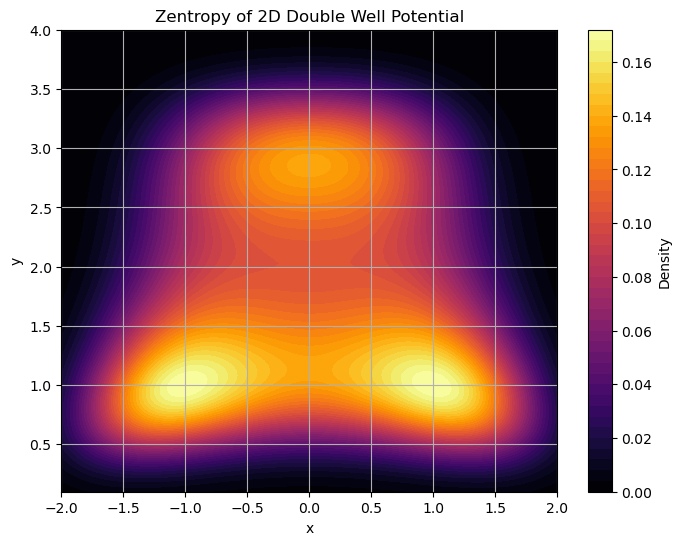

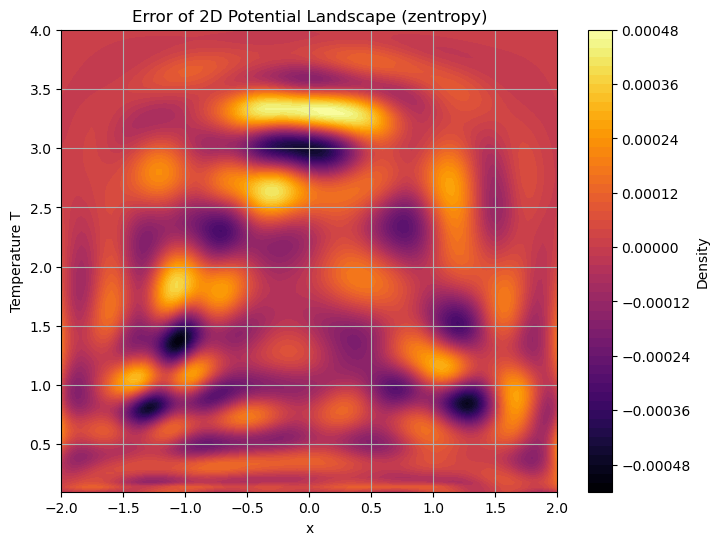

In [83]:
kb=1.0
Nf = 100
X_train = torch.linspace(xmin, xmax, Nf, dtype=torch.float64, device = device)  # 输入 x
T_train = torch.linspace(Tmin, Tmax, Nf, dtype=torch.float64, device = device)  # 
X, T = torch.meshgrid(X_train, T_train, indexing='ij')  # Shape [50, 50]

positions = torch.stack([X.ravel(), T.ravel()], dim=1)  # Shape [2500, 2]

X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)

with torch.no_grad():
    z_pred = model(X_T_train)
#print(z_pred.shape)

dx = (xmax-xmin)/(Nf-1)
dT = (Tmax-Tmin)/(Nf-1)
T = X_T_train[:, 1].unsqueeze(1)
z_pred = (1/dx)*(1/dT)*torch.softmax(-z_pred/(kb*T), dim=0)
z_pred = z_pred.cpu().numpy().reshape(X.shape)
plt.figure(figsize=(8,6))
plt.contourf(X_train, T_train, z_pred.T, levels=50, cmap="inferno")
plt.colorbar(label="Density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Zentropy of 2D Double Well Potential")
plt.grid()
plt.show()

# Define x and temperature range
x_vals = torch.linspace(-2, 2, Nf)
T_vals = torch.linspace(0.1, 4.0, Nf)
X, T = torch.meshgrid(x_vals, T_vals)

# Compute potential landscape
V_vals = V(X, T)

# Compute Boltzmann probability and normalize over x and T
P_vals = boltzmann_probability(V_vals, x_vals, T_vals)

# Convert to NumPy for plotting
X_np = X.numpy()
T_np = T.numpy()
V_np = V_vals.numpy()
P_np = P_vals.numpy()

# Plot 2D Contour of Potential Landscape
plt.figure(figsize=(8,6))
contour = plt.contourf(X_np, T_np, z_pred-P_np/(dx*dT), levels=50, cmap="inferno")
plt.colorbar(label="Density")

# Labels & Title
plt.xlabel("x")
plt.ylabel("Temperature T")
plt.title("Error of 2D Potential Landscape (zentropy)")

# Grid & Show
plt.grid()
plt.show()


In [84]:
kb=1.0
Nf = 100
X_train = torch.linspace(xmin, xmax, Nf, dtype=torch.float64, device = device)  # 输入 x
T_train = torch.linspace(Tmin, Tmax, Nf, dtype=torch.float64, device = device)  # 
X, T = torch.meshgrid(X_train, T_train, indexing='ij')  # Shape [50, 50]

positions = torch.stack([X.ravel(), T.ravel()], dim=1)  # Shape [2500, 2]

X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)
with torch.no_grad():
    z_pred = model(X_T_train)
#print(z_pred.shape)

dx = (xmax-xmin)/(Nf-1)
dT = (Tmax-Tmin)/(Nf-1)
T = X_T_train[:, 1].unsqueeze(1)
z_pred = (1/dx)*(1/dT)*torch.softmax(-z_pred/(kb*T), dim=0)
#z_pred = z_pred / T
z_pred_np = z_pred.cpu().numpy().reshape(X.shape)  # Move to CPU and convert to NumPy
# print(z_pred[0:49])
np.savetxt("y_pred_bifurcation_80.txt", z_pred_np, fmt="%.6f")  # Save with 6 decimal places


/var/folders/hf/8zl6jp_n1s1gzshd65cd_79r0000gn/T/ipykernel_4565/3325267024.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_T_train = torch.tensor(positions, dtype=torch.float64, device=device)


In [85]:
# # Generate value
# xmin = -2
# xmax = 2
# Tmin = 0.1
# Tmax = 4
# Nf = 100
# NT = 100
# dx = (xmax-xmin)/(Nf-1)
# dT = (Tmax-Tmin)/(NT-1)
# V = torch.linspace(xmin, xmax, Nf).reshape(-1, 1)  # x values
# T_vals = torch.linspace(Tmin, Tmax, NT).reshape(-1, 1)  # Temperature values

# # Compute Gradient for Free Energy
# gradients_list = []
# second_derivatives_list = []

# print("First Temperature Value (T_vals[0]):", T_vals[0].item())  # Print first temperature value

# for i in range(Nf):  # Iterate over one temperature value
#     T_scalar = T_vals[i].item()  # Convert T_vals[i] from tensor to scalar
#     T_tensor = torch.full((Nf, 1), T_scalar, dtype=torch.float64)  # Expand T value for all x

#     X_T_train = torch.cat([V,T_tensor], dim=1)
#     X_T_train.requires_grad = True  # Enable differentiation before model call

#     z_pred = model(X_T_train)
    
#     # z_pred = (1/dx)*(1/dT)*torch.softmax(-z_pred/(kb*T_scalar), dim=0)
#     # y_pred = -torch.log(z_pred)
#     y_pred = (z_pred) / T_scalar
#     # print(X_T_train)
#     # print(y_pred)
#     # Compute first-order gradient (∂y/∂x)
#     first_derivative = torch.autograd.grad(
#         outputs=y_pred,
#         inputs=X_T_train,
#         grad_outputs=torch.ones_like(y_pred),
#         create_graph=True
#     )[0][:, 0]  # Select derivative w.r.t. x only

#     gradients_list.append(first_derivative.detach().cpu().numpy())  # Store first derivative

#     # Compute second-order gradient (∂²y/∂x²)
#     second_derivative = torch.autograd.grad(
#         outputs=first_derivative,
#         inputs=X_T_train,
#         grad_outputs=torch.ones_like(first_derivative),
#         create_graph=True
#     )[0][:, 0]  # Select second derivative w.r.t. x only

#     second_derivatives_list.append(second_derivative.detach().cpu().numpy())  # Store second derivative


# # Convert to NumPy array and Transpose
# first_derivatives_array = np.array(gradients_list).T  # Transpose
# second_derivatives_array = np.array(second_derivatives_list).T  # Transpose

# # Print computed second derivatives
# print("Computed Second Derivatives (Transposed):", second_derivatives_array.shape)

# # Save Transposed First and Second Derivatives to File
# np.savetxt("CZ_y_pred_bifurcation_gradient.txt", first_derivatives_array, fmt="%.10f")
# np.savetxt("CZ_y_pred_bifurcation_Hessian.txt", second_derivatives_array, fmt="%.10f")
# print("First and Second derivatives saved to text files!")
